In [44]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import matplotlib.dates as mdates

from datetime import datetime
from typing import List

In [45]:
# Leitura dos dados e tratamento
df_inmet = pd.read_csv(
    filepath_or_buffer="../dados/inmet/dados_A401_H_2001-01-01_2022-08-23.csv", sep=";", header=9
)
df_nasa = pd.read_csv(
    filepath_or_buffer="../dados/nasa/A401.csv", sep=","
)



In [46]:
# Tira colunas que não serão utilizadas
df_inmet = df_inmet[["Hora Medicao", "Data Medicao", "RADIACAO GLOBAL(Kj/m²)"]]
df_nasa.drop(["QV2M", df_nasa.columns[0], df_nasa.columns[-1]], axis=1, inplace=True)

In [47]:
# Converter a data e hora do inmet no formato datetime.
def converter_dados_inmet_em_datetime(data_series: pd.Series, hora_series: pd.Series):

    hora_series = (hora_series/100).map(int)

    data_horario_series: List[datetime] = []
    
    assert len(hora_series) == len(data_series)
    for i in range(len(hora_series)):
        data_str = data_series.iloc[i]
        data = datetime(year=int(data_str[0:4]), month=int(data_str[5:7]),  day=int(data_str[8:10]), hour=hora_series[i], minute=0, second=0)
        data_horario_series.append(data)
    return pd.Series(data_horario_series)

def converter_dados_nasa_em_datetime(year_s: pd.Series, mes_s: pd.Series, dia_s: pd.Series, hora_s: pd.Series):

    data_horario_series: List[datetime] = []

    for i in range(len(year_s)):
        data = datetime(year=int(year_s.iloc[i]), month=int(mes_s.iloc[i]),  day=int(dia_s.iloc[i]), hour=hora_s.iloc[i], minute=0, second=0)
        data_horario_series.append(data)
    return pd.Series(data_horario_series)



In [48]:
# Cria uma coluna com data + horario no INMET
df_inmet["Data_Horario"] = converter_dados_inmet_em_datetime(df_inmet["Data Medicao"].copy(), df_inmet["Hora Medicao"].copy())
# Cria uma coluna com data + horario na NASA
df_nasa["Data_Horario"] = converter_dados_nasa_em_datetime(df_nasa["YEAR"].copy(), df_nasa["MO"].copy(), df_nasa["DY"].copy(), df_nasa["HR"].copy())

# Exclusao das Colunas Temporais separadas
df_inmet.drop(labels=["Data Medicao", "Hora Medicao"], axis=1, inplace=True)
df_nasa.drop(labels=["YEAR", "MO", "DY", "HR"], axis=1, inplace=True)

# Index no Data_Horario
df_inmet.set_index(keys="Data_Horario", inplace=True)
df_nasa.set_index(keys="Data_Horario", inplace=True)

In [49]:
# Junta os Dataframes
df_inmet_nasa = df_nasa.join(other=df_inmet,how='left')
df_inmet_nasa.reset_index(inplace=True)

In [50]:
# Visualizacao
# Titulos das features
titulos = [
    "Temperatura (°C)",
    "Temperatura de Orvalho (°C)",
    "Temperatura de Bulbo Úmido (°C)",
    "Umidade Relativa (%)",
    "Precipitação Média (mm/hora)",
    "Pressão na Superfície (kPa)",
    "Direção do vento a 10m (°)",
    "Velocidade do vento a 10m (m/s)",
    "Direção do vento a 50m (°)",
    "Velocidade do vento a 50m (m/s)",
    "Radiação Global (Kj/m²)",
]

keys_features = [
    "T2M",
    "T2MDEW",
    "T2MWET",
    "RH2M",
    "PRECTOTCORR",
    "PSC",
    "WD10M",
    "WS10M",
    "WD50M",
    "WS50M",
    "RADIACAO GLOBAL(Kj/m²)"
]

cores = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "black",
    "turquoise",
    "palegreen",
]

nome_coluna_data = "Data_Horario"

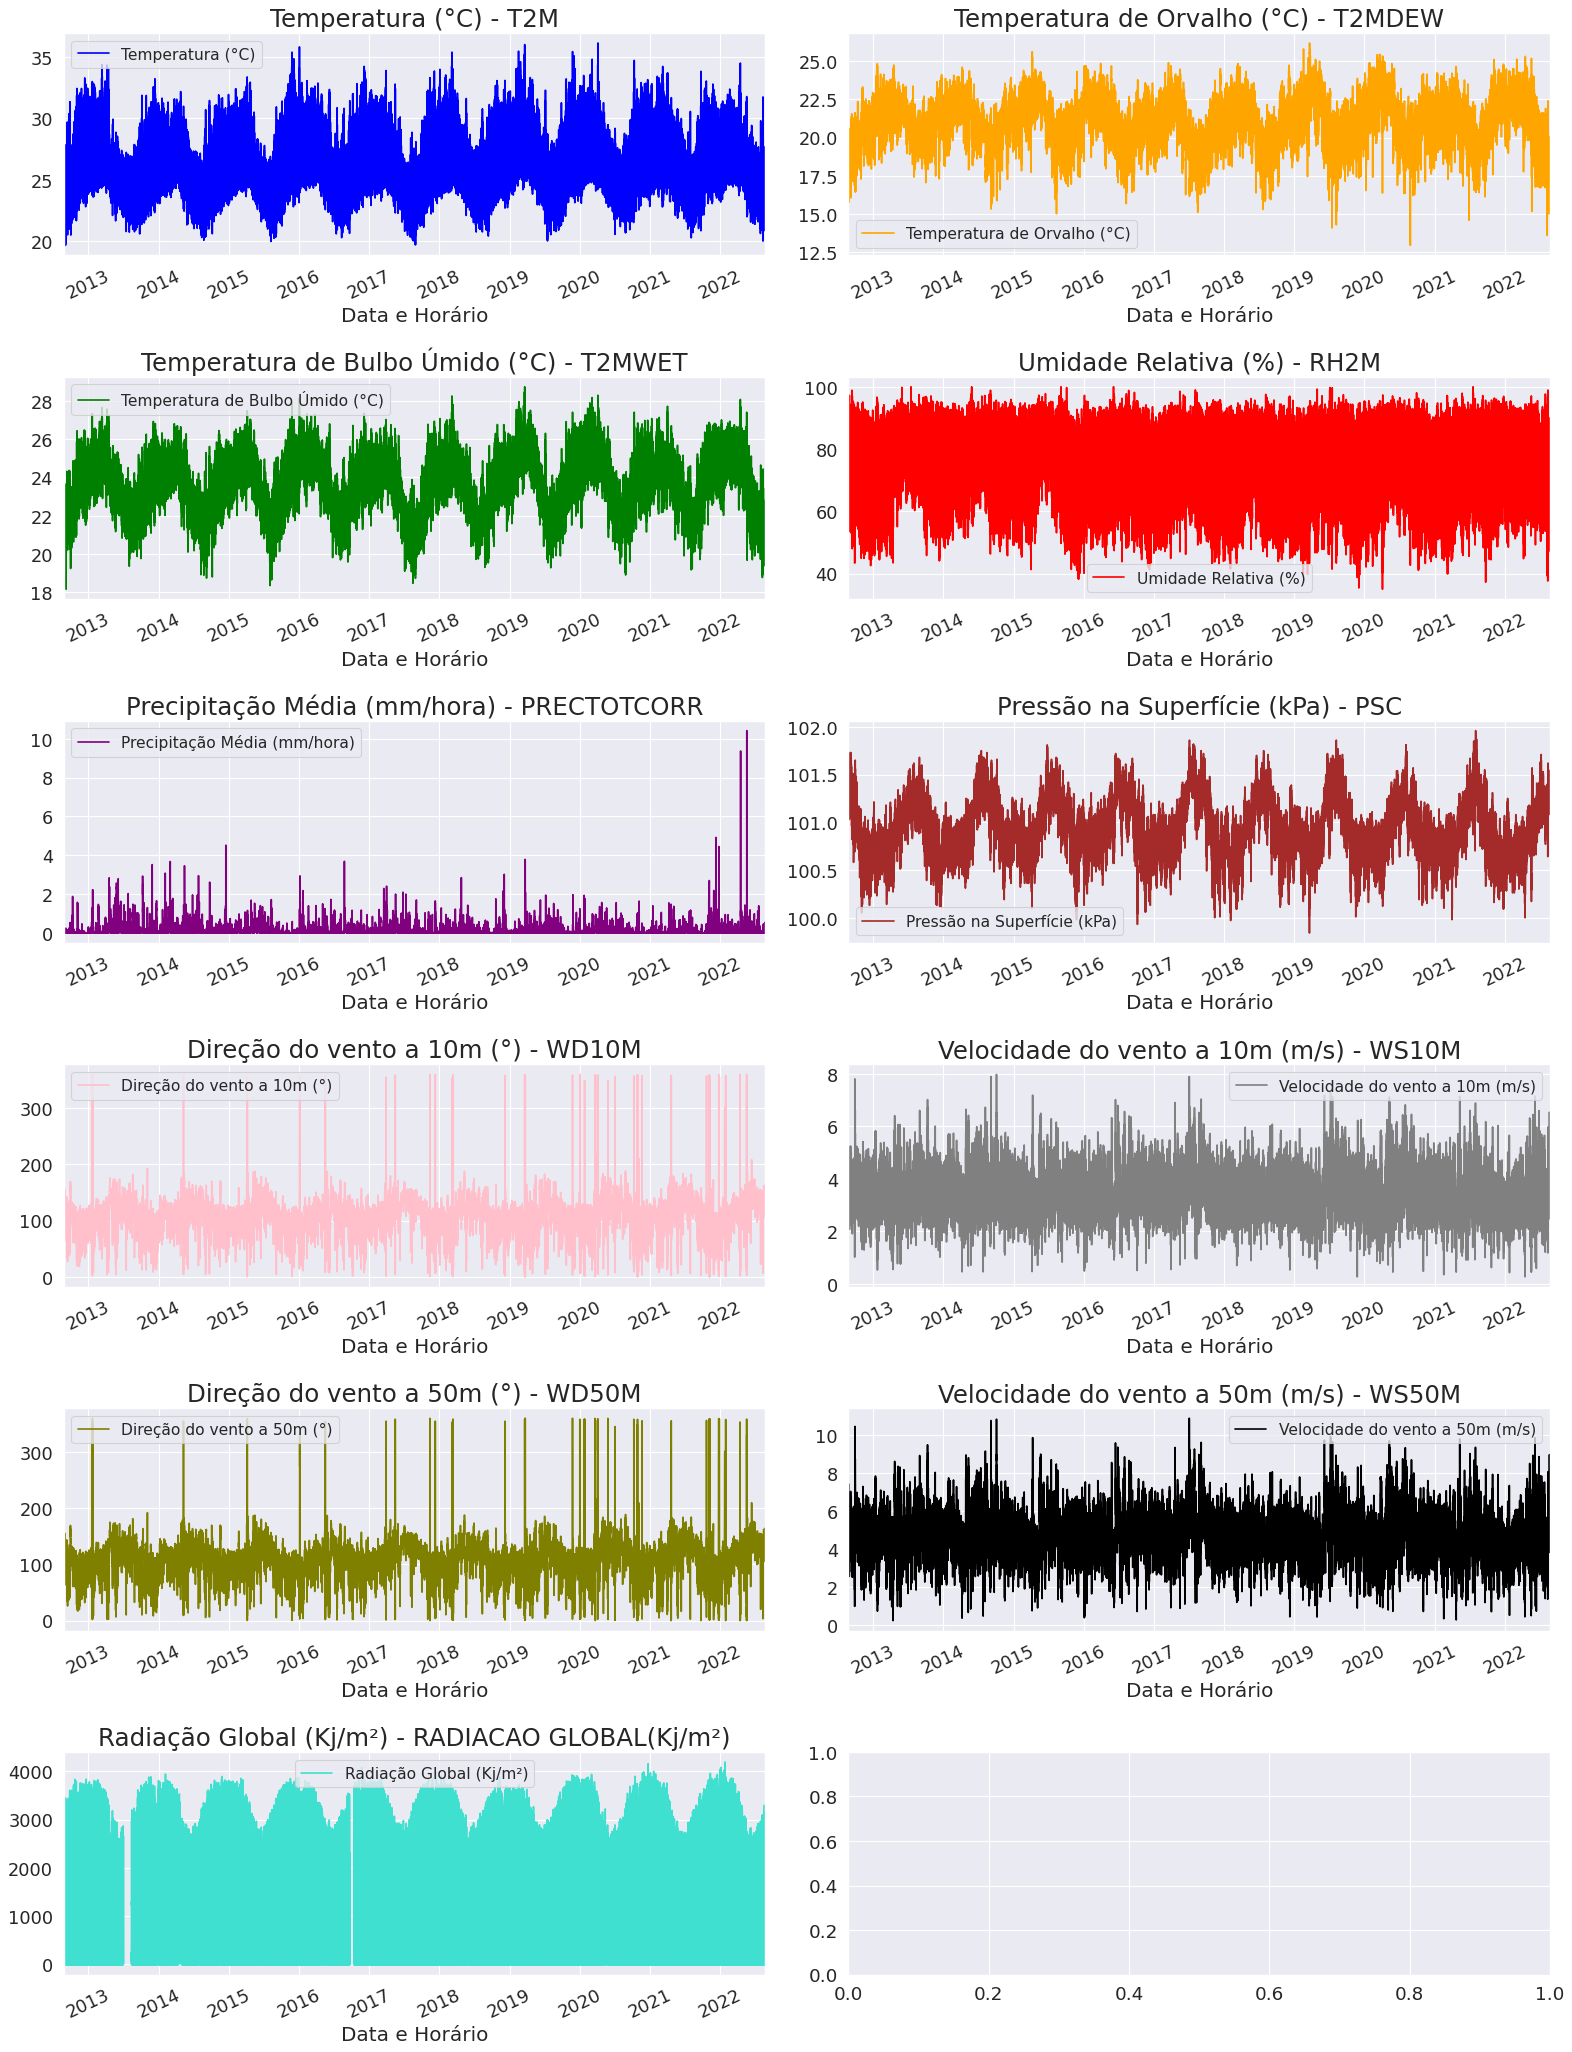

In [51]:
# Visualização dos Dados Completos
def visualizacao(data):
    time_data = data[nome_coluna_data]
    fig, axes = plt.subplots(
        nrows=6, ncols=2, figsize=(20, 26), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(keys_features)):
        key = keys_features[i]
        c = cores[i % (len(cores))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titulos[i], key),
            rot=25,
        )
        ax.legend([titulos[i]], fontsize=14)
        ax.set_title("{} - {}".format(titulos[i], key), fontsize=22)
        ax.set_xlabel("Data e Horário", fontsize=18)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()

visualizacao(data=df_inmet_nasa)

In [52]:
# Pre-tratamento dos dados

def replace_negative(x):
    if x < 0:
        return 0.0
    else:
        return x

# Substituição de todos os valores negativos de Radiação Global por valores positivos
df_inmet_nasa['RADIACAO GLOBAL(Kj/m²)'] = df_inmet_nasa['RADIACAO GLOBAL(Kj/m²)'].apply(replace_negative).reset_index(drop=True)

# Tratamento de valores nulos
# Tentativa a) Aprendizado com a média para o horário e mês, tirado de todos os anos
df_inmet_nasa = df_inmet_nasa.set_index(keys="Data_Horario")
df_inmet_nasa_colunas_tratadas = df_inmet_nasa[keys_features]
df_inmet_nasa_group = df_inmet_nasa_colunas_tratadas.groupby([df_inmet_nasa_colunas_tratadas.index.month, df_inmet_nasa_colunas_tratadas.index.day, df_inmet_nasa_colunas_tratadas.index.hour]).transform('mean')
df_inmet_nasa = df_inmet_nasa.fillna(df_inmet_nasa_group)
df_inmet_nasa = df_inmet_nasa.reset_index()


# Conversão de Radiação Global em kJ/m² para Irradiância em W/m² (a média)
df_inmet_nasa['IRRADIÂNCIA'] = df_inmet_nasa['RADIACAO GLOBAL(Kj/m²)']*(1000/(60*60))

df_inmet_nasa.drop(labels=['RADIACAO GLOBAL(Kj/m²)'], axis=1, inplace=True)

titulos = [
    "Temperatura (°C)",
    "Temperatura de Orvalho (°C)",
    "Temperatura de Bulbo Úmido (°C)",
    "Umidade Relativa (%)",
    "Precipitação Média (mm/hora)",
    "Pressão na Superfície (kPa)",
    "Direção do vento a 10m (°)",
    "Velocidade do vento a 10m (m/s)",
    "Direção do vento a 50m (°)",
    "Velocidade do vento a 50m (m/s)",
    "Irradiância (W/m²)",
]

keys_features = [
    "T2M",
    "T2MDEW",
    "T2MWET",
    "RH2M",
    "PRECTOTCORR",
    "PSC",
    "WD10M",
    "WS10M",
    "WD50M",
    "WS50M",
    "IRRADIÂNCIA"
]

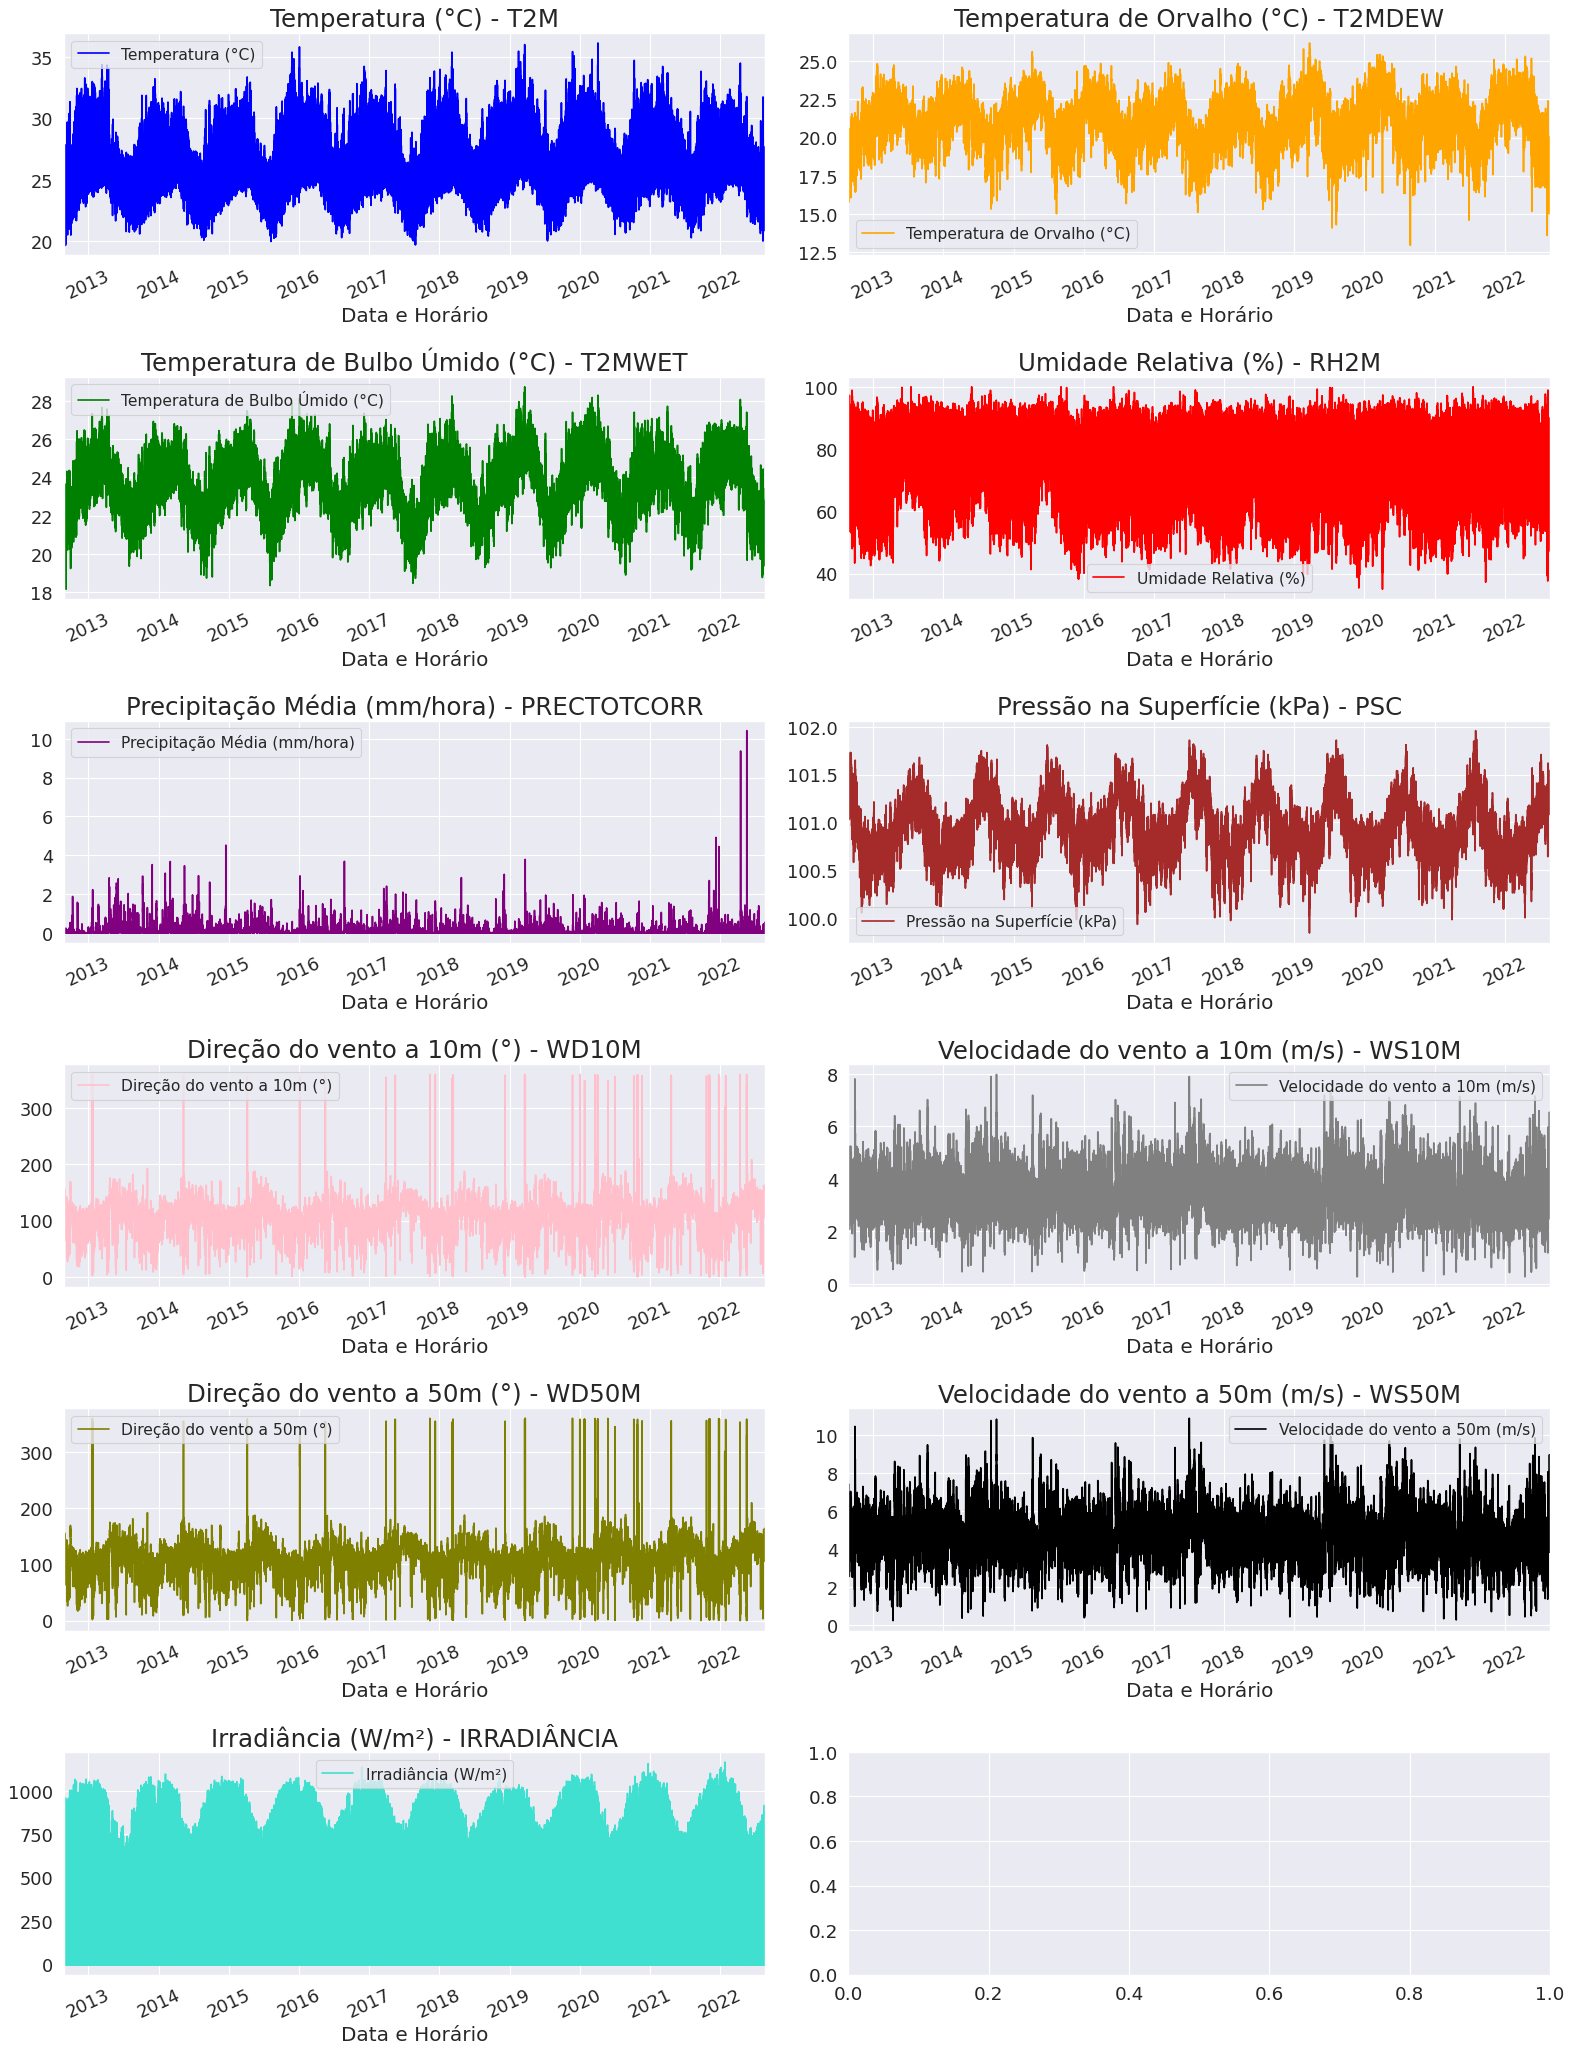

In [53]:
# Visualizacao
visualizacao(data=df_inmet_nasa)

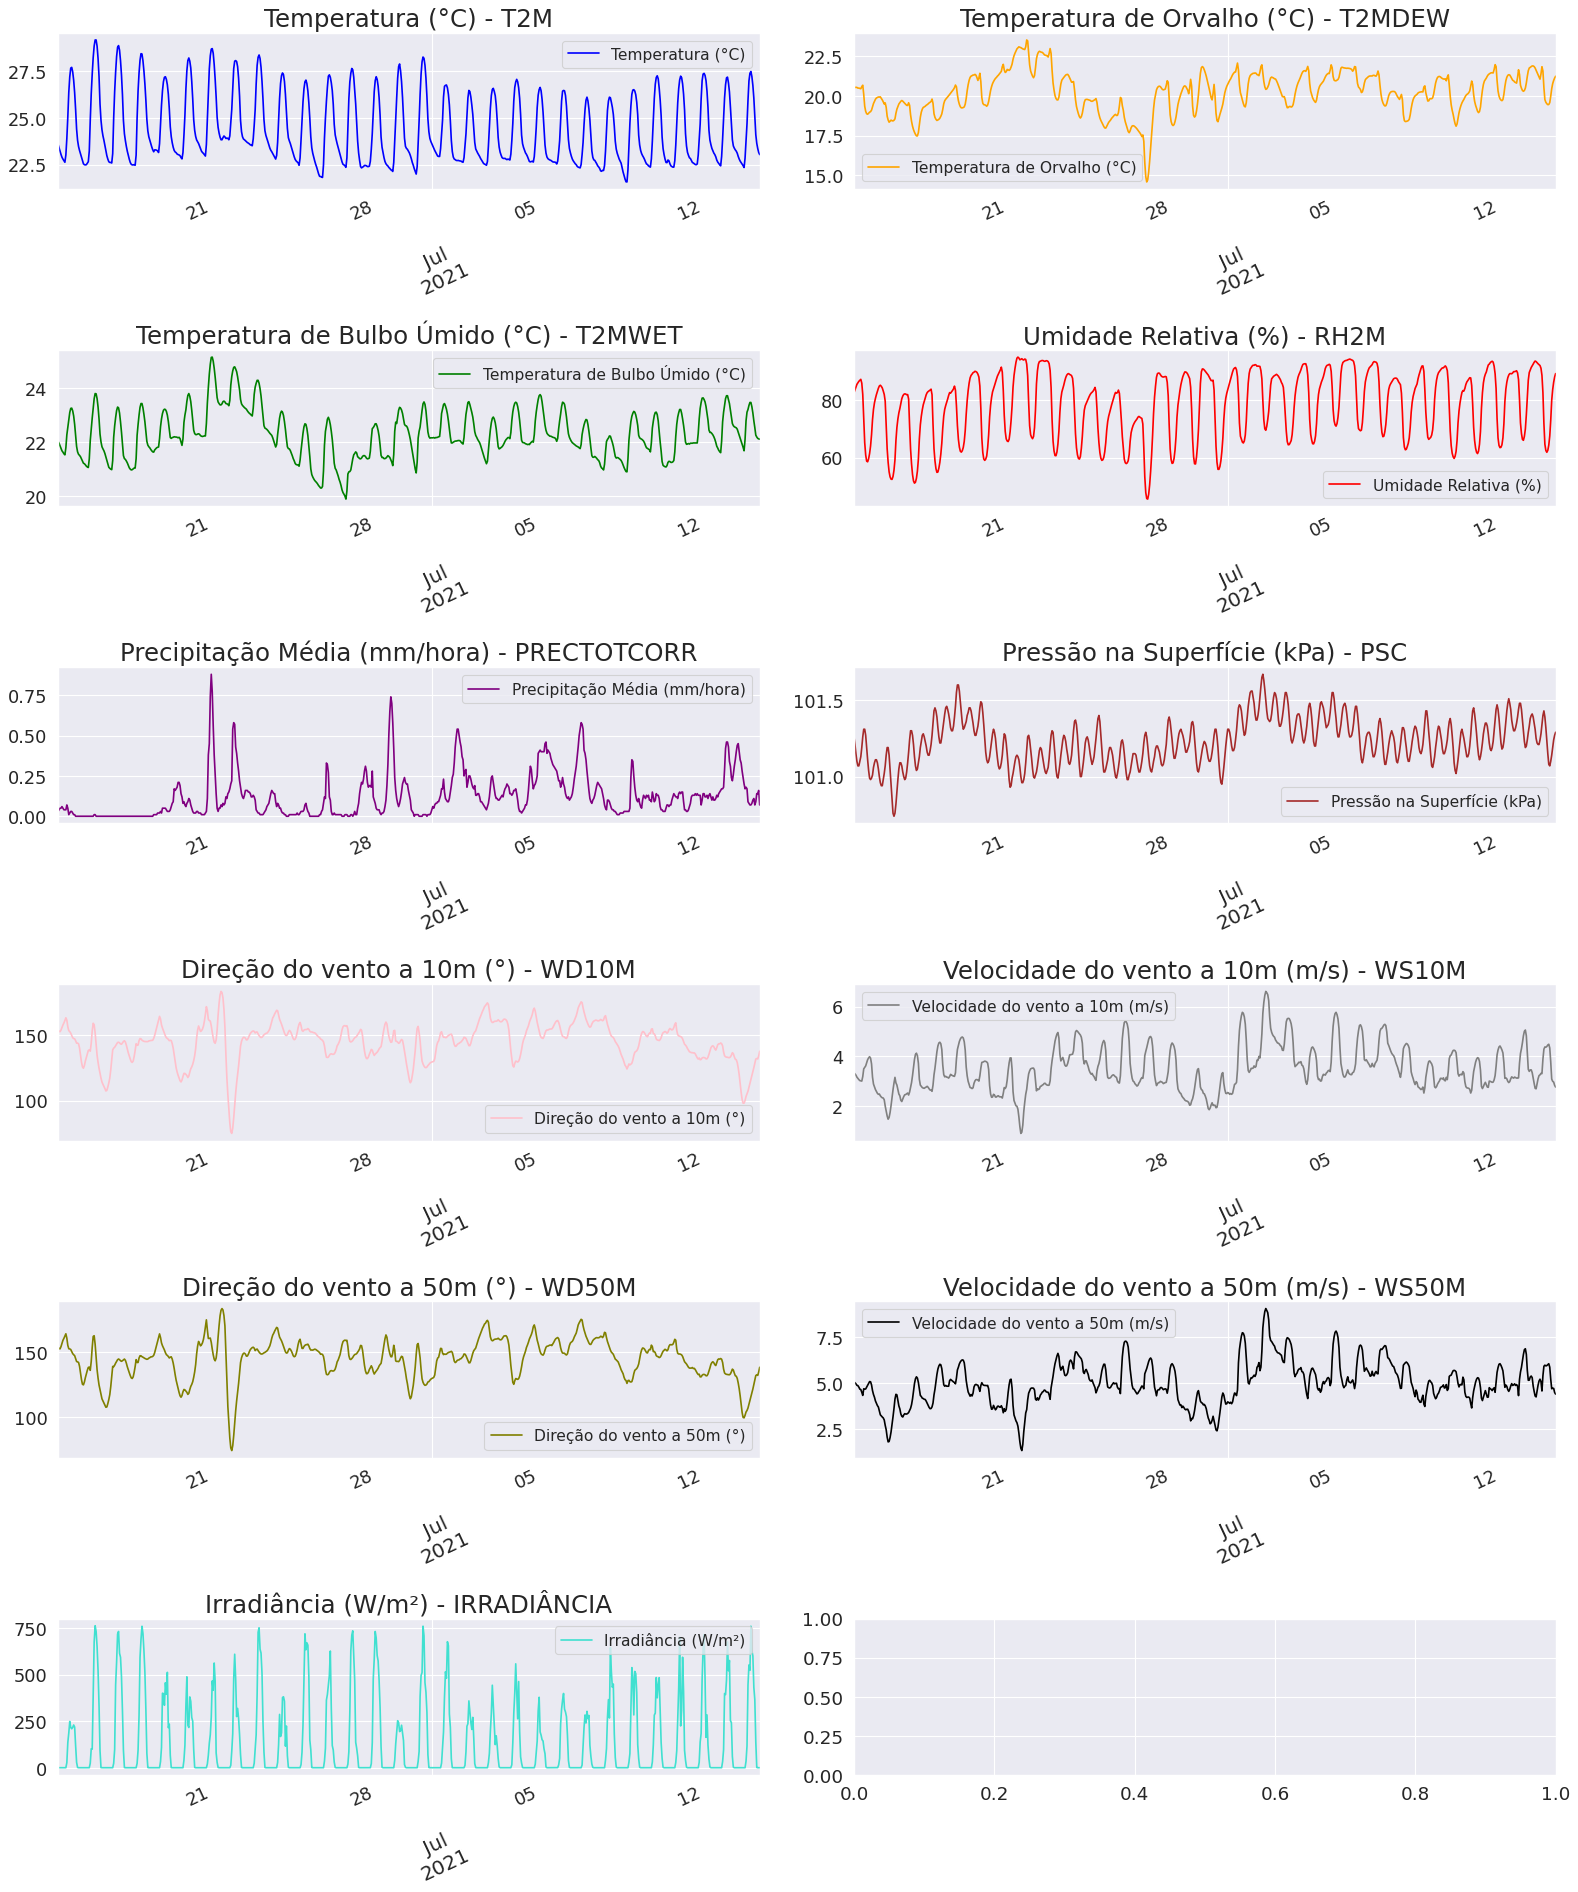

In [54]:
# Plot de um período de 1 mes, para visualização
start_date = '2021-06-15'
end_date   = '2021-07-15'
date_1_mes_mask = (df_inmet_nasa['Data_Horario'] > start_date) & (df_inmet_nasa['Data_Horario'] <= end_date)
df_a_1_mes = df_inmet_nasa.loc[date_1_mes_mask]

def visualizacao_1_mes(data): 
    
    time_data = data[nome_coluna_data]
    fig, axes = plt.subplots(
        nrows=6, ncols=2, figsize=(20, 24), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(keys_features)):
        key = keys_features[i]
        c = cores[i % (len(cores))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titulos[i], key),
            rot=25,
        )
        ax.legend([titulos[i]], fontsize=14)
        ax.set_title("{} - {}".format(titulos[i], key), fontsize=22)
        ax.set_xlabel("", fontsize=18)
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='x', which="minor", labelsize=16)

        ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()

visualizacao_1_mes(data=df_a_1_mes)

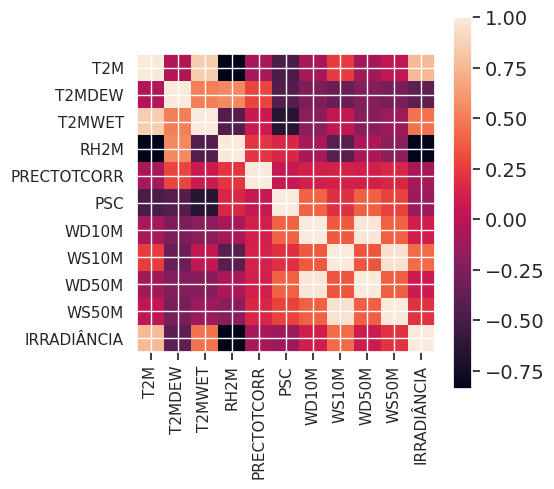

In [55]:
# Heatmap de correlação entre dados (caso_a)
def mostrar_correlacao(dados):
    plt.matshow(dados.corr())
    plt.xticks(range(dados.shape[1]), dados.columns, fontsize=11, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(dados.shape[1]), dados.columns, fontsize=11)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.show()


mostrar_correlacao(dados=df_inmet_nasa[keys_features])

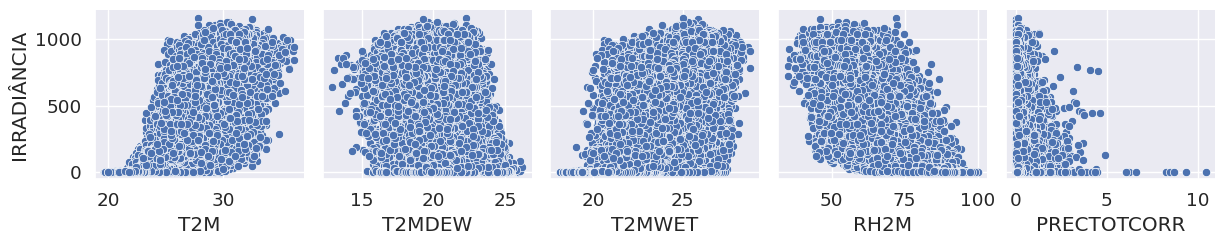

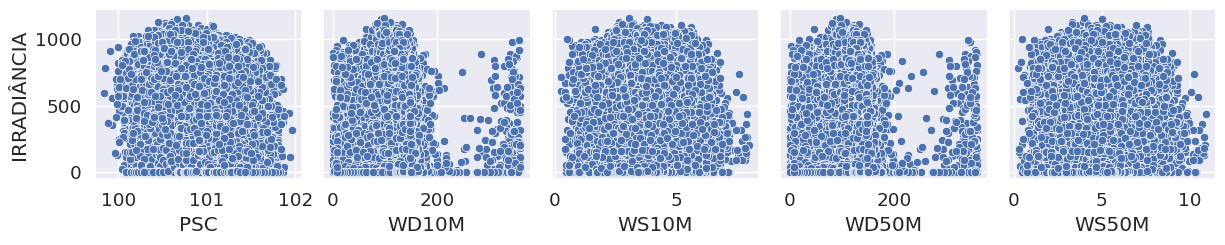

In [56]:

def annotate(x, y, **kws):
    r, p = sp.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    

sns.set(font_scale=1.2)

pp = sns.pairplot(data=df_inmet_nasa,
                  y_vars=['IRRADIÂNCIA'],
                  x_vars=['T2M', 'T2MDEW', 'T2MWET', 'RH2M', 'PRECTOTCORR'],
                )
pp.map_lower(annotate)

pp2 = sns.pairplot(data=df_inmet_nasa,
                  y_vars=['IRRADIÂNCIA'],
                  x_vars=['PSC', 'WD10M', 'WS10M', 'WD50M', 'WS50M'],
                )

pp2.map_lower(annotate)
plt.show()

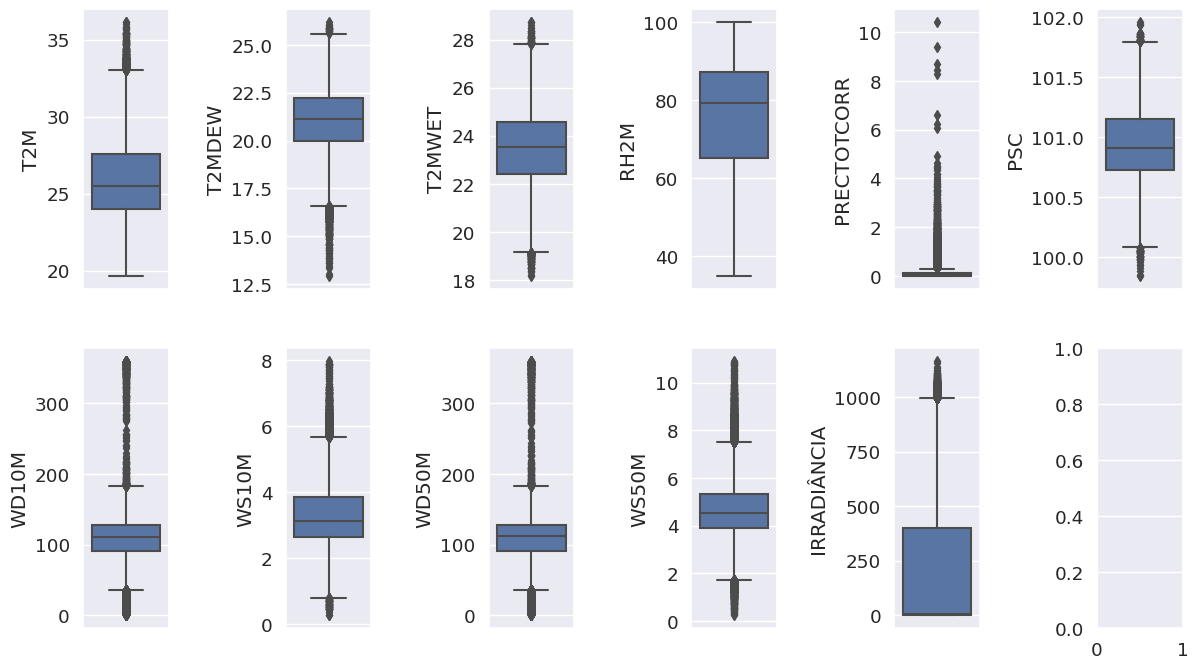

In [57]:
fig, ax = plt.subplots(2, 6, figsize=(12, 7))
fig.tight_layout(w_pad=3)
sns.set(font_scale=1.5)
index = 0
for column in df_inmet_nasa[keys_features]:
    if index < 6:
        sns.boxplot(data=df_inmet_nasa[keys_features], y=column, ax=ax[0][index])
    else: 
        sns.boxplot(data=df_inmet_nasa[keys_features], y=column, ax=ax[1][index-6])

    index = index+1



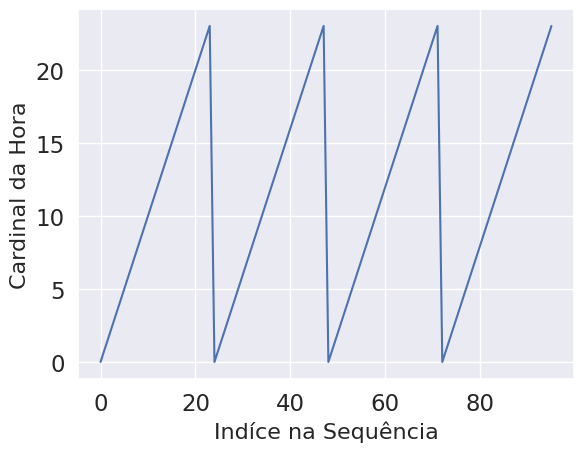

In [58]:
hora = df_inmet_nasa["Data_Horario"].dt.hour
amostras = hora[:96]
plt.figure()
plt.plot(amostras)
plt.xlabel("Indíce na Sequência", fontsize=16)
plt.ylabel("Cardinal da Hora", fontsize=16)
plt.show()

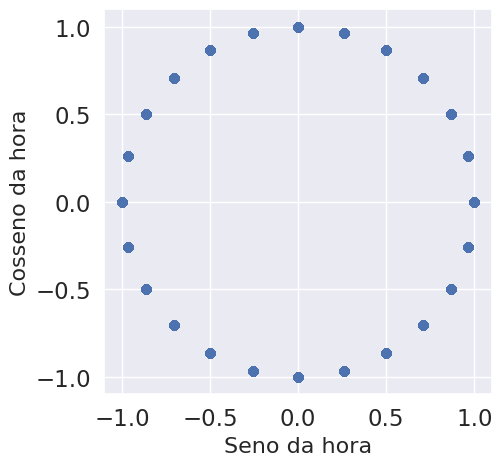

In [59]:
# Criando uma Feature Cíclica representado a posição da Hora no Dia
hora_cos = [np.cos(x * (2 * np.pi / 24)) for x in hora]
hora_sin = [np.sin(x * (2 * np.pi / 24)) for x in hora]
plt.figure(figsize=(5,5))
plt.scatter(x=hora_cos, y=hora_sin)
plt.xlabel('Seno da hora', fontsize=16)
plt.ylabel('Cosseno da hora', fontsize=16)
plt.show()

In [35]:
# Salva os Dados Pré-processados
df_inmet_nasa.to_csv('../dados/pre_processado/salvador.csv')